# Dissociated and spatial data integration with DiagVI

DiagVI (Diagonal Variational Inference) is a multi-modal integration method that aligns unpaired datasets across different modalities. It produces a joint latent representation of cells, enables cross-modal imputation, and supports label transfer between modalities.
In this tutorial, we demonstrate how to use DiagVI to integrate dissociated single-cell RNA sequencing (scRNA-seq) data with spatial transcriptomics data from mouse gastrulation embryos.

We use two publicly available datasets:
- Spatial transcriptomics (seqFISH): The spatial data are from [Lohoff et al.](https://www.nature.com/articles/s41587-021-01006-2), consisting of sagittal sections from three mouse embryos collected between embryonic day E8.5 and E8.75. For this tutorial, we focus on a subset of the data comprising 57,536 cells from the E8.5 embryos.
- Dissociated scRNA-seq: The dissociated data are from [Pijuan-Sala et al.](https://www.nature.com/articles/s41586-019-0933-9), profiling 166,312 cells across embryonic days E6.5 to E8.5, and providing a comprehensive reference atlas of early mouse development.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [ ]:
!pip install --quiet scvi-colab
!pip install --quiet cellmapper
from scvi_colab import install

install()

## Imports and data loading

In [ ]:
import os
import tempfile
import warnings
import warnings

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import torch
from cellmapper import CellMapper
from scvi.external import DIAGVI
from scib_metrics.benchmark import Benchmarker

In [43]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.4.1


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [44]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

### Data Aquisition 

In [90]:
ad_diss = sc.read("data/ad_diss.h5ad", backup_url="https://figshare.com/ndownloader/files/54145217")
ad_diss

AnnData object with n_obs × n_vars = 16496 × 18499
    obs: 'barcode', 'sample_rna', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype_rna', 'haem_subclust', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutDPT', 'endo_gutCluster', 'sizefactor', 'modality', 'total_counts', 'n_counts', 'celltype_harmonized'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_harmonized_colors', 'celltype_rna_colors', 'cluster_colors', 'hvg', 'pca', 'sample_colors', 'sequencing.batch_colors', 'stage_colors', 'theiler_colors', 'umap'
    obsm: 'X_endo_gephi', 'X_endo_gut', 'X_haem_gephi', 'X_pca', 'X_umap', 'X_umap_orig'
    varm: 'PCs'

In [91]:
ad_sp = sc.read("data/ad_sp.h5ad", backup_url="https://figshare.com/ndownloader/files/54145250")
ad_sp

AnnData object with n_obs × n_vars = 51787 × 351
    obs: 'embryo', 'pos', 'z', 'embryo_pos', 'embryo_pos_z', 'Area', 'celltype_seqfish', 'sample_seqfish', 'umap_density_sample', 'modality', 'total_counts', 'n_counts', 'celltype_harmonized'
    uns: 'celltype_harmonized_colors', 'celltype_seqfish_colors', 'embryo_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_orig', 'spatial'
    varm: 'PCs'

### Data Preprocessing
We begin by preprocessing the raw dissociated and spatial datasets. The workflow follows the steps described in the [preprocessing tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/use_cases/preprocessing.html#multiome).

In [25]:
# Preprocess spatial data
ad_sp.layers["counts"] = ad_sp.X.copy()
ad_sp.var["original_feature_name"] = ad_sp.var.index.copy()

sc.pp.normalize_total(ad_sp, target_sum=1e4)
sc.pp.log1p(ad_sp)

In [26]:
# Preprocess dissociated data
ad_diss.layers["counts"] = ad_diss.X.copy()
ad_diss.var["original_feature_name"] = ad_diss.var.index.copy()

sc.pp.normalize_total(ad_diss, target_sum=1e4)
sc.pp.log1p(ad_diss)
sc.pp.highly_variable_genes(ad_diss)

print(f"Computed {ad_diss.var['highly_variable'].sum()} highly variable genes")

Computed 1677 highly variable genes


We subset the dissociated data to the union of highly variable genes and spatially measured genes. This ensures the model can learn from the full set of informative genes.

In [10]:
genes_diss = (
    ad_sp.var_names.union(ad_diss.var.query("highly_variable").index)
    .intersection(ad_diss.var_names)
)
ad_diss = ad_diss[:, genes_diss].copy()

print(f"Spatial data dimensions: {ad_sp.shape}")
print(f"Dissociated data dimensions: {ad_diss.shape}")

Spatial data dimensions: (51787, 351)
Dissociated data dimensions: (16496, 1780)


### Data Visualization

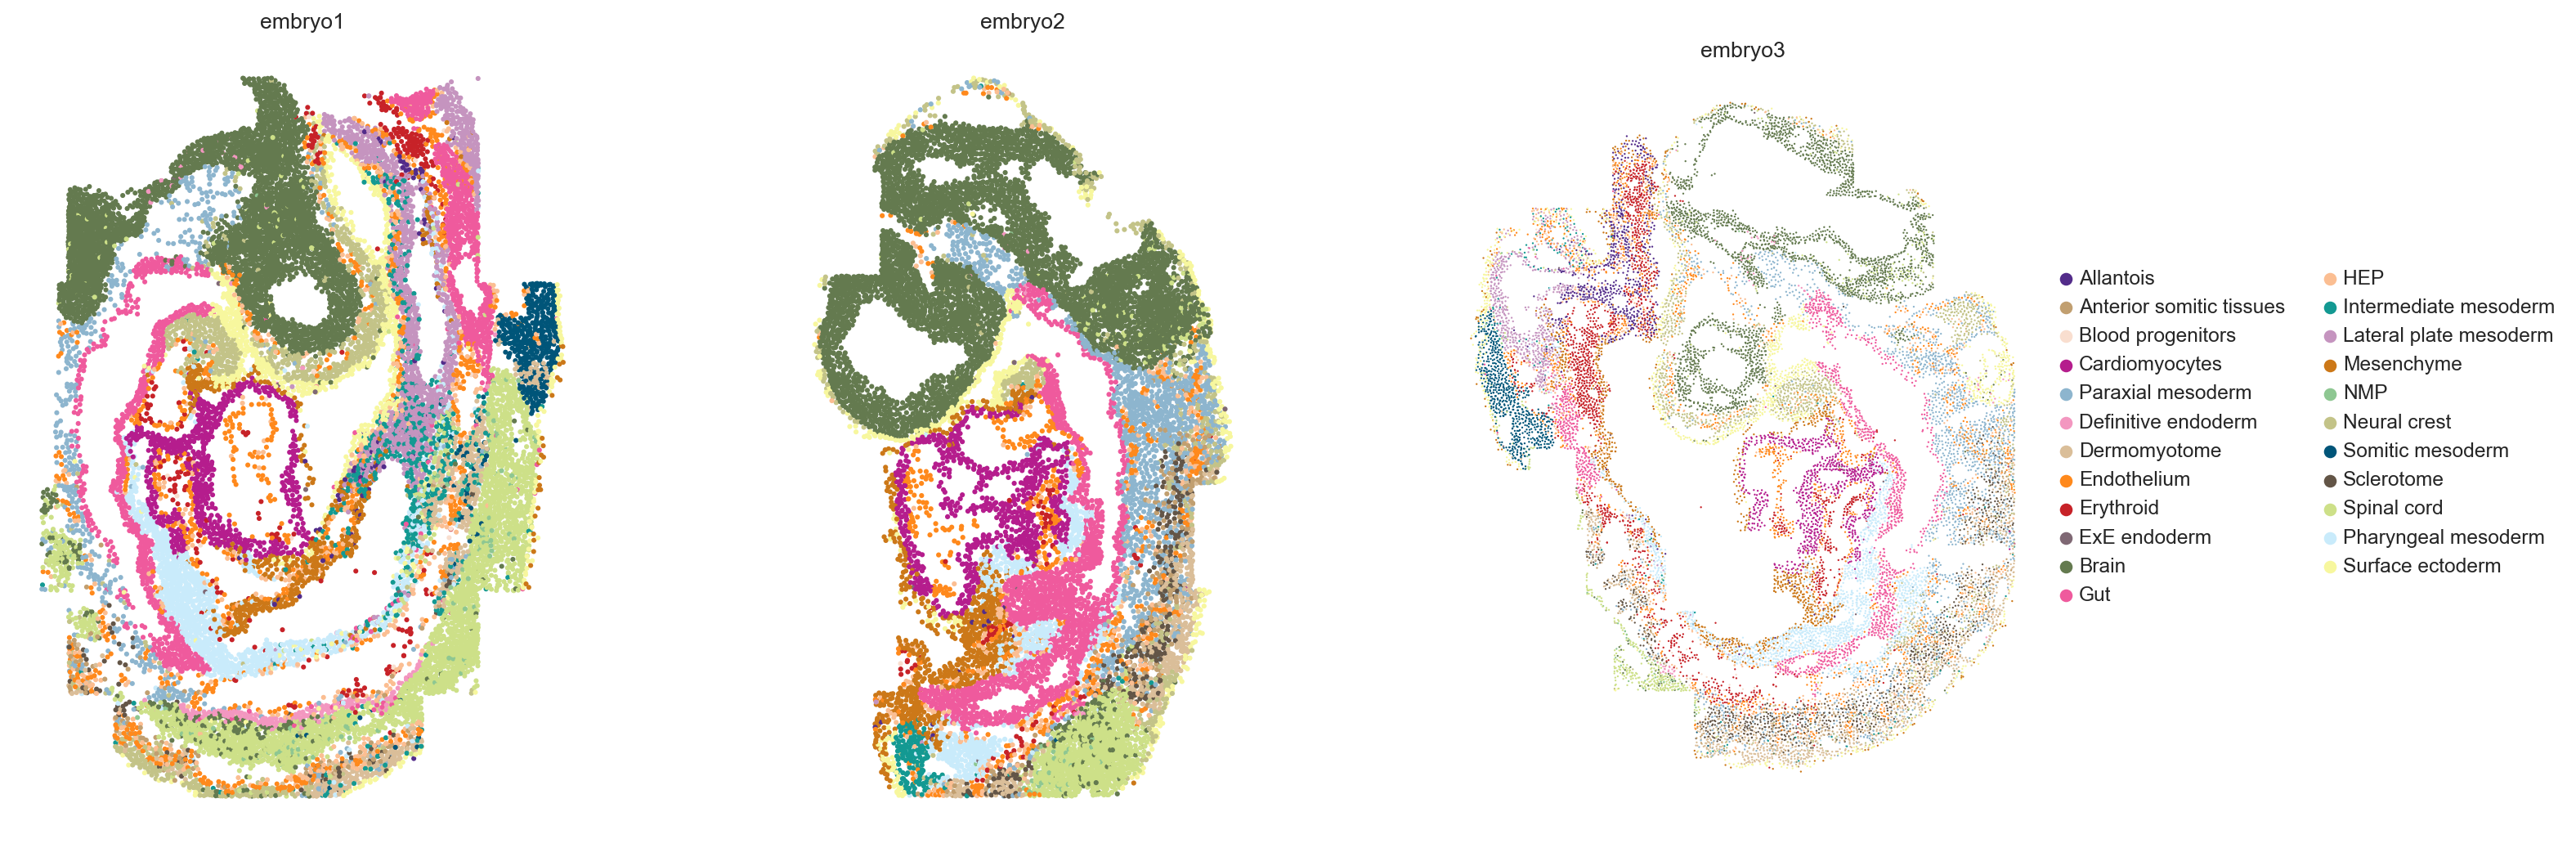

In [ ]:
# Visualize spatial data for all embryos side-by-side
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    for idx, embryo in enumerate(["embryo1", "embryo2", "embryo3"]):
        sc.pl.spatial(
            ad_sp[ad_sp.obs["embryo"] == embryo],
            color="celltype_harmonized",
            spot_size=1.5,
            show=False,
            ax=axes[idx],
            title=embryo,
            legend_loc="right margin" if idx == 2 else None,
        )

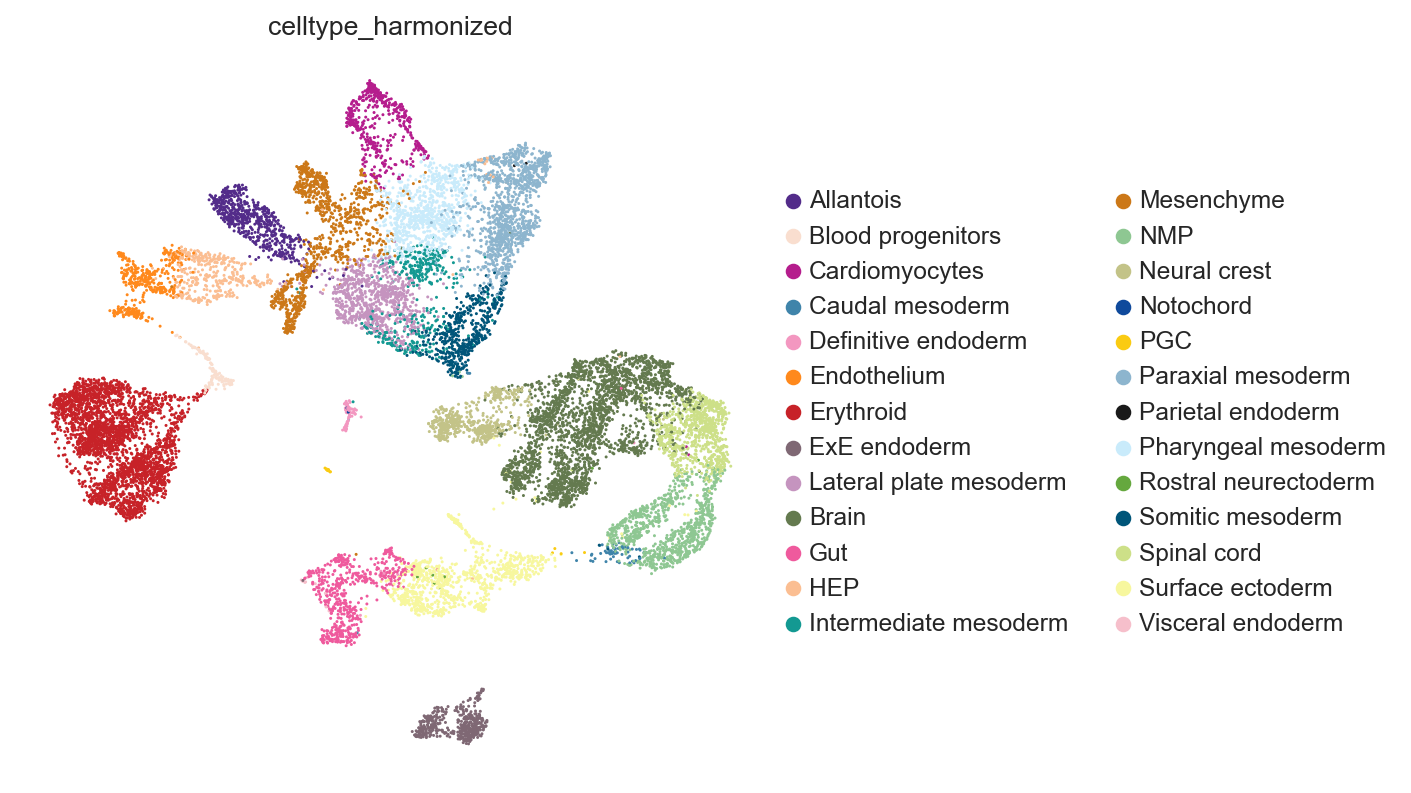

In [46]:
# Visualize dissociated data UMAP
sc.pl.embedding(ad_diss, basis="X_umap", color="celltype_harmonized")

## Prepare and run DiagVI

### Setup AnnData objects

We register each AnnData object with DiagVI using `setup_anndata`.

```{important}
Key parameters for `setup_anndata`:

- `layer`: Specifies which layer contains raw counts for model input (e.g., "counts")
- `batch_key`: Column in `.obs` containing batch information to correct for
- `likelihood`:Likelihood function used to model gene expression counts. Supported options include:  
  - `"nb"`: Negative binomial (default; recommended for count data)  
  - `"zinb"`: Zero-inflated negative binomial  

Additional configuration options are available. For (spatial) transcriptomics data, we recommend using either `"nb"` or `"zinb"`.
```

In [47]:
DIAGVI.setup_anndata(
    ad_diss,
    layer="counts",
    batch_key="sample_rna",
    likelihood="nb",
)

DIAGVI.setup_anndata(
    ad_sp,
    layer="counts",
    batch_key="embryo",
    likelihood="nb",
)

Next, we create the DiagVI model object by providing a dictionary that maps modality names (chosen by the user) to their corresponding AnnData objects.

There are three ways to specify the guidance graph:

-  Automatic construction (default): If neither `guidance_graph` nor `mapping_df` is provided, DiagVI constructs a graph from overlapping feature names across modalities (e.g., shared gene symbols).

-  Custom mapping via DataFrame: Pass a `pandas.DataFrame` to `mapping_df` where each column corresponds to a modality name (matching the keys in `input_dict`) and each row specifies a feature pair. This is useful when feature naming conventions differ between modalities. You can also use `DIAGVI.construct_custom_guidance_graph` to create a graph with custom edge weights and signs.

-  Explicit graph specification: For full control, pass a pre-constructed `torch_geometric.data.Data` object directly to `guidance_graph`. The graph must include node features, edge indices, edge weights, edge signs, and modality-specific feature index tensors.

In [49]:
input_dict = {"scRNAseq": ad_diss, "seqFISH": ad_sp}
model = DIAGVI(adatas=input_dict)

INFO     Guidance graph consistency checks passed.                                                                 
INFO     Decoder for 'scRNAseq' (likelihood=nb): DecoderSinglePathway, normalize=True                              
INFO     Decoder for 'seqFISH' (likelihood=nb): DecoderSinglePathway, normalize=True                               
INFO     DiagVI Model with the following params: input names: ['scRNAseq', 'seqFISH'], n_inputs: {'scRNAseq':      
         18499, 'seqFISH': 351}, n_batches: {'scRNAseq': 4, 'seqFISH': 3}, generative distributions: {'scRNAseq':  
         'nb', 'seqFISH': 'nb'},  n_latent: 50, n_hidden: 256, n_layers: 2.                                        


In [50]:
model

DiagVI Model with the following params: input names: ['scRNAseq', 'seqFISH'], n_inputs: {'scRNAseq': 18499, 
'seqFISH': 351}, n_batches: {'scRNAseq': 4, 'seqFISH': 3}, generative distributions: {'scRNAseq': 'nb', 'seqFISH': 
'nb'},  n_latent: 50, n_hidden: 256, n_layers: 2.
Training status: Not Trained

### Train the model
DiagVI's training objective combines several loss components. These can be weighted using `plan_kwargs`.

```{note}
Key training parameters in `plan_kwargs`:

- `lam_kl`: Weight for KL divergence regularization of the latent space.
- `lam_data`:Weight for the reconstruction loss.
- `lam_graph`: Weight for the guidance graph loss, which encourages feature embeddings of corresponding features across modalities to align in latent space.
- `lam_sinkhorn`: Weight for the unbalanced optimal transport (Sinkhorn) loss, which aligns cell distributions across modalities.
```

```{important}
These hyperparameters may require tuning depending on the dataset. Refer to the user guide for more information.
```

In [ ]:
model.train(
    max_epochs=30,
    batch_size=256,
    plan_kwargs={
        "lam_kl": 1.0,
        "lam_data": 0.1,
        "lam_graph": 10.0,
        "lam_sinkhorn": 1,
    },
)

/Users/hannahwinter/Documents/ETH/MasterThesis/DiagVI/scvi-tools-public/src/scvi/external/diagvi/_model.py:216: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch/Jax operations are supported with this backend. as a result, some models might be slower and less accurate than usual. Please verify your analysis!Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  accelerator, devices, device = parse_device_args(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/hannahwinter/Documents/ETH/MasterThesis/DiagVI/diagVI_analysis/.pixi/envs/default/lib/python3.12/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstan

Training:   0%|          | 0/30 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


## Analyze outputs
### Visualize the latent space

First, we retrieve the latent representations for both modalities to compute a joint UMAP embedding.

In [ ]:
DIAGVI_LATENT_KEY = "X_diagvi"

latents = model.get_latent_representation()
ad_diss.obsm[DIAGVI_LATENT_KEY] = latents["scRNAseq"]
ad_sp.obsm[DIAGVI_LATENT_KEY] = latents["seqFISH"]

combined = sc.concat([ad_diss, ad_sp], axis=0, join="inner")

In [62]:
# Preserve cell type colors from both datasets
colors_diss = dict(
    zip(
        ad_diss.obs["celltype_harmonized"].cat.categories,
        ad_diss.uns["celltype_harmonized_colors"],
        strict=False,
    )
)
colors_sp = dict(
    zip(
        ad_sp.obs["celltype_harmonized"].cat.categories,
        ad_sp.uns["celltype_harmonized_colors"],
        strict=False,
    )
)

color_lookup = colors_diss | colors_sp
combined.uns["celltype_harmonized_colors"] = [
    color_lookup[cat] for cat in combined.obs["celltype_harmonized"].cat.categories
]

In [ ]:
DIAGVI_UMAP_KEY = "X_umap_diagvi"

sc.tl.pca(combined)
sc.pp.neighbors(combined, use_rep=DIAGVI_LATENT_KEY, metric="cosine")
sc.tl.umap(combined, key_added=DIAGVI_UMAP_KEY)

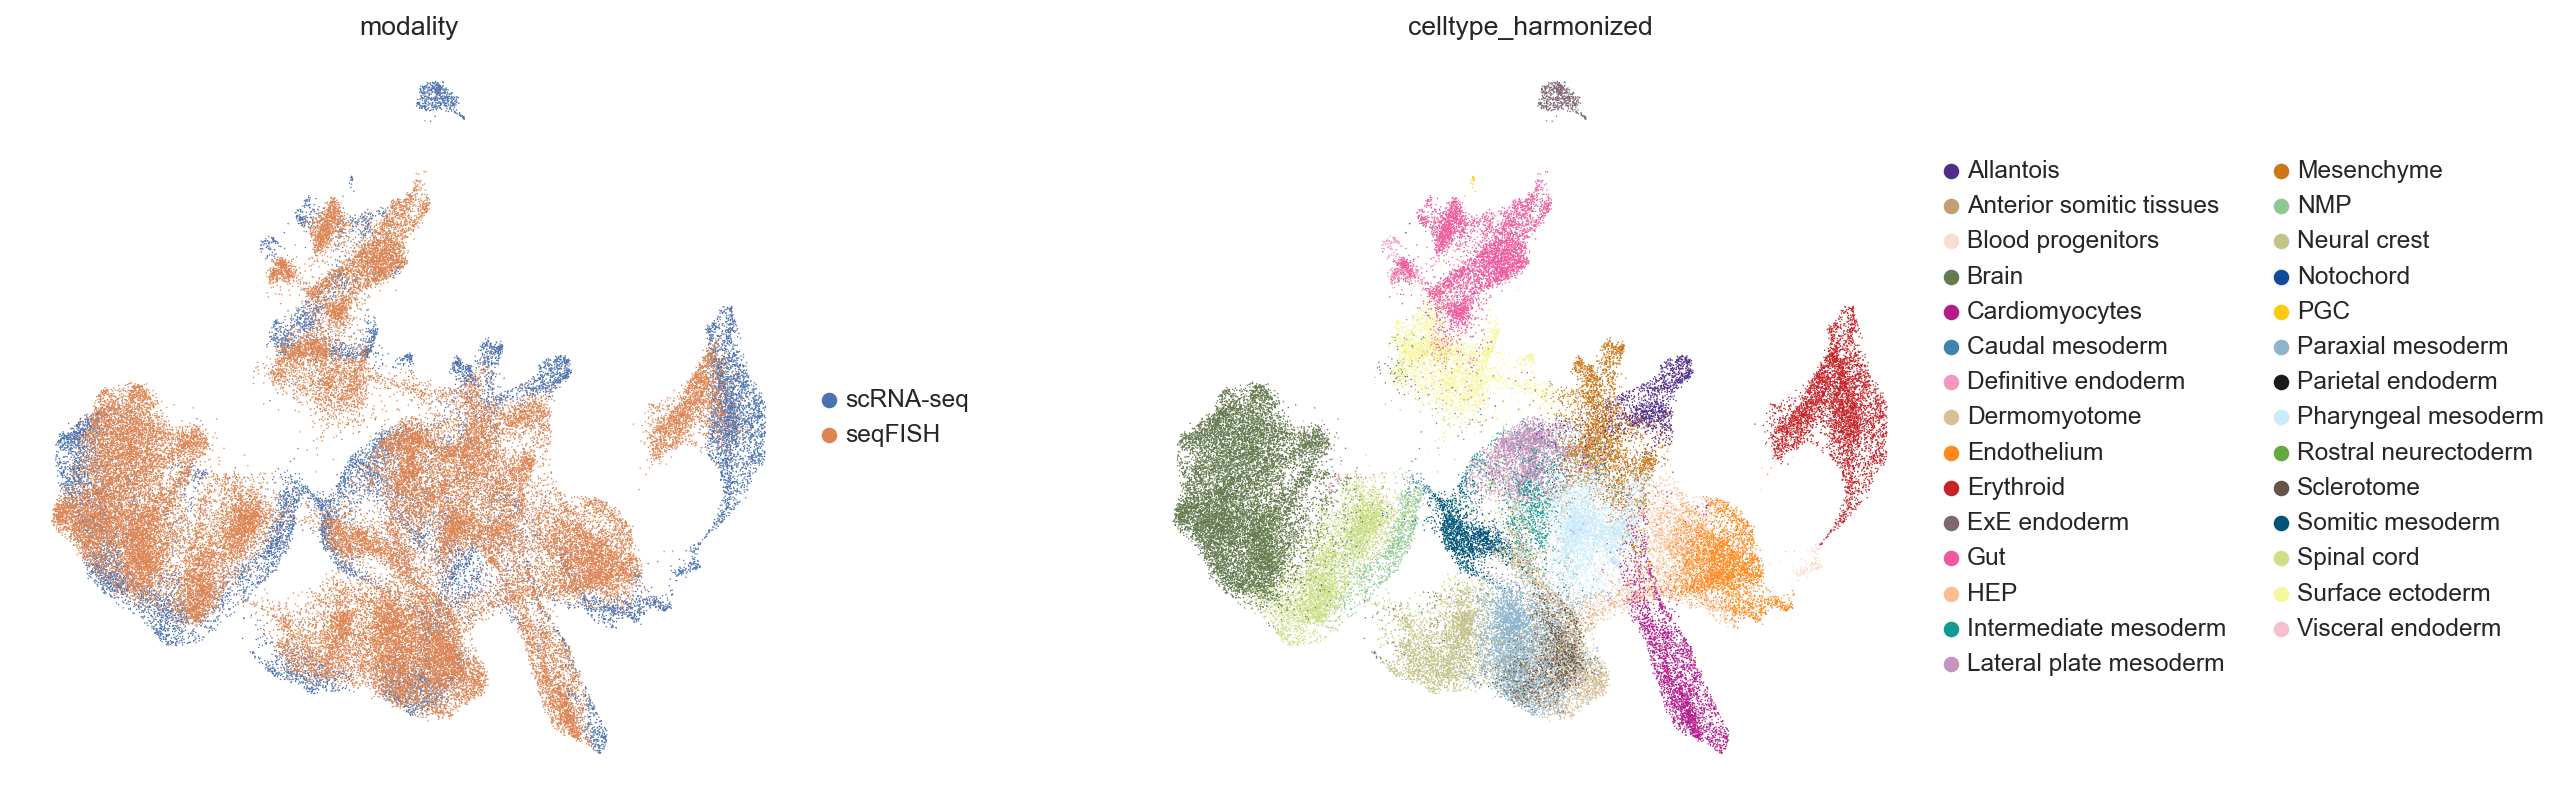

In [64]:
sc.pl.embedding(
    combined,
    basis="umap_diagvi",
    color=["modality", "celltype_harmonized"],
    wspace=0.3,
    ncols=2,
)

We see that cells from both modalities (scRNA-seq and seqFISH) are well-mixed in the joint latent space, while cell types remain separated. This indicates successful integration.

### Impute missing features
A key application of DiagVI is imputing expression values for genes that were not measured in the spatial data. Since spatial transcriptomics technologies like seqFISH only measure a limited panel of genes, DiagVI can leverage the learned cross-modal mapping to predict expression of all genes profiled in the scRNA-seq reference for each spatial cell. We use the `get_imputed_values` method to obtain these predictions.

In [71]:
imputed_values = model.get_imputed_values(source_name="seqFISH", source_adata=ad_sp)

To evaluate imputation quality, we use [CellMapper](https://cellmapper.readthedocs.io/), a toolkit for cross-modal cell mapping and evaluation. Here, we leverage CellMapper's evaluation functionality to compute Pearson correlations between the original measured expression and the DiagVI-imputed values for genes present in both modalities.

In [72]:
cmap = CellMapper(query=ad_sp, reference=ad_diss)
cmap.query_imputed = imputed_values
cmap.evaluate_expression_transfer(layer_key="counts", groupby="embryo")

INFO     Initialized CellMapper with 51787 query cells and 16496 reference cells.                                  
INFO     Imputed expression matrix with shape (51787, 18499) converted to AnnData object.                          
         Observation metadata from query and feature metadata from reference were linked (not copied).             
INFO     Expression transfer evaluation (pearson): average value = 0.4940 (n_shared_genes=350, n_test_genes=350)   
INFO     Metrics per group defined in `query.obs['embryo']` computed and stored in `query.varm['metric_pearson']`  


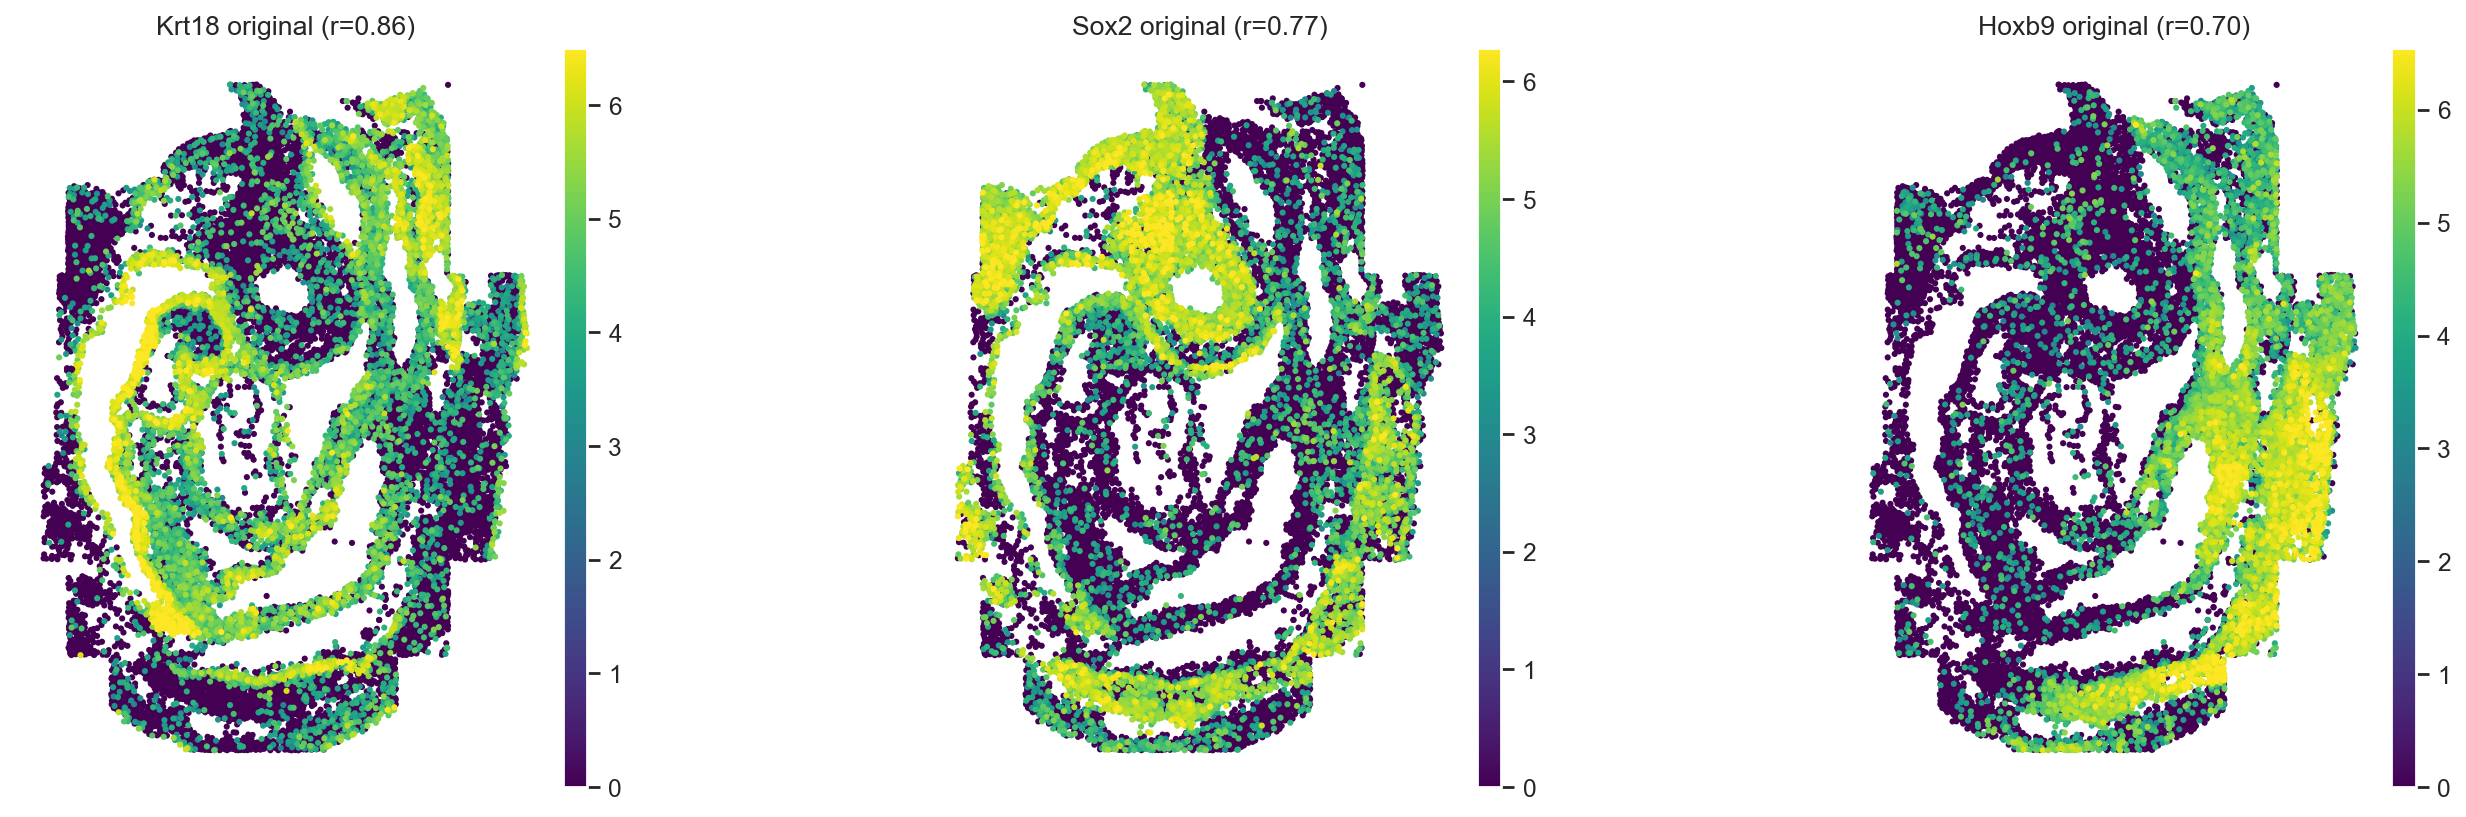

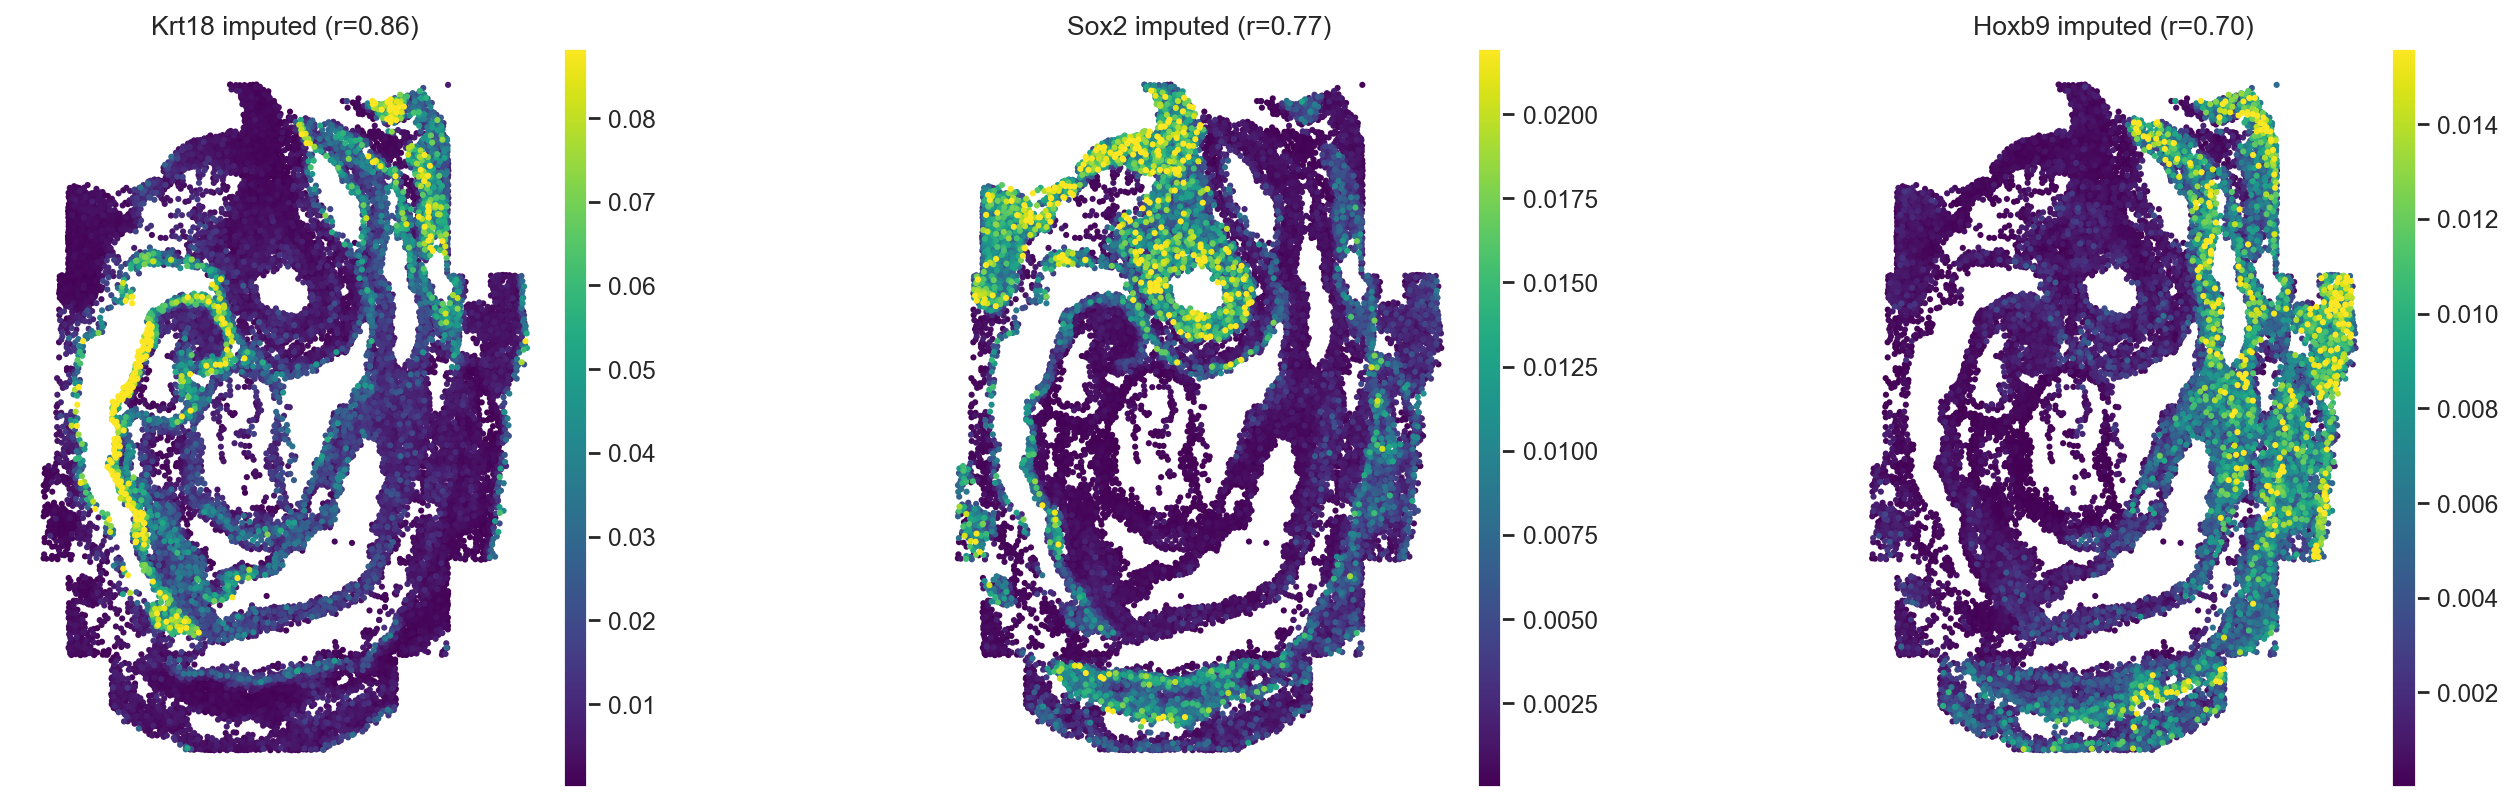

In [73]:
# Visualization original and imputed expression values for three genes in embryo1
obs_mask = ad_sp.obs["embryo"] == "embryo1"
gene_names = ["Krt18", "Sox2", "Hoxb9"]
gene_corrs = ad_sp.var.loc[gene_names]["metric_pearson"].values

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for adata, key in zip(
        [ad_sp[obs_mask], cmap.query_imputed[obs_mask]],
        ["original", "imputed"],
        strict=False,
    ):
        sc.pl.spatial(
            adata,
            spot_size=1,
            color=gene_names,
            title=[
                f"{name} {key} (r={corr:.2f})"
                for name, corr in zip(gene_names, gene_corrs, strict=False)
            ],
            ncols=len(gene_names),
            size=2,
            cmap = "viridis",
            vmax="p99",
        )

### Transfer cell type labels

Another key application is transferring cell type annotations from a well-annotated reference to unannotated or partially annotated query data. 
Here, we treat the spatial dataset as unlabeled and transfer cell type annotations from the scRNA-seq reference using the DiagVI latent space.
We use CellMapper to perform k-nearest neighbor (KNN)–based mapping and to compute prediction confidence scores for each transferred label.

In [74]:
cmap = CellMapper(query=ad_sp, reference=ad_diss)
cmap.compute_neighbors(use_rep=DIAGVI_LATENT_KEY)

INFO     Initialized CellMapper with 51787 query cells and 16496 reference cells.                                  
WARNING  Using sklearn for neighbor search with large dataset (16496 cells). Consider using approximate k-NN search
         (e.g. pynndescent) or GPU acceleration (e.g. faiss or rapids)                                             
INFO     Using sklearn to compute 30 neighbors.                                                                    


In [78]:
cmap.compute_mapping_matrix()
cmap.map_obs("celltype_harmonized")
cmap.evaluate_label_transfer(label_key="celltype_harmonized")

INFO     Computing mapping matrix using kernel method 'gauss'.                                                     
INFO     Mapping categorical data for key 'celltype_harmonized' using direct multiplication.                       
INFO     Categorical data mapped and stored in query.obs['celltype_harmonized_pred'].                              
INFO     Accuracy: 0.7015, Precision: 0.7237, Recall: 0.7015, Weighted F1-Score: 0.6914, Macro F1-Score: 0.4907,   
         Excluded Fraction: 0.0000                                                                                 


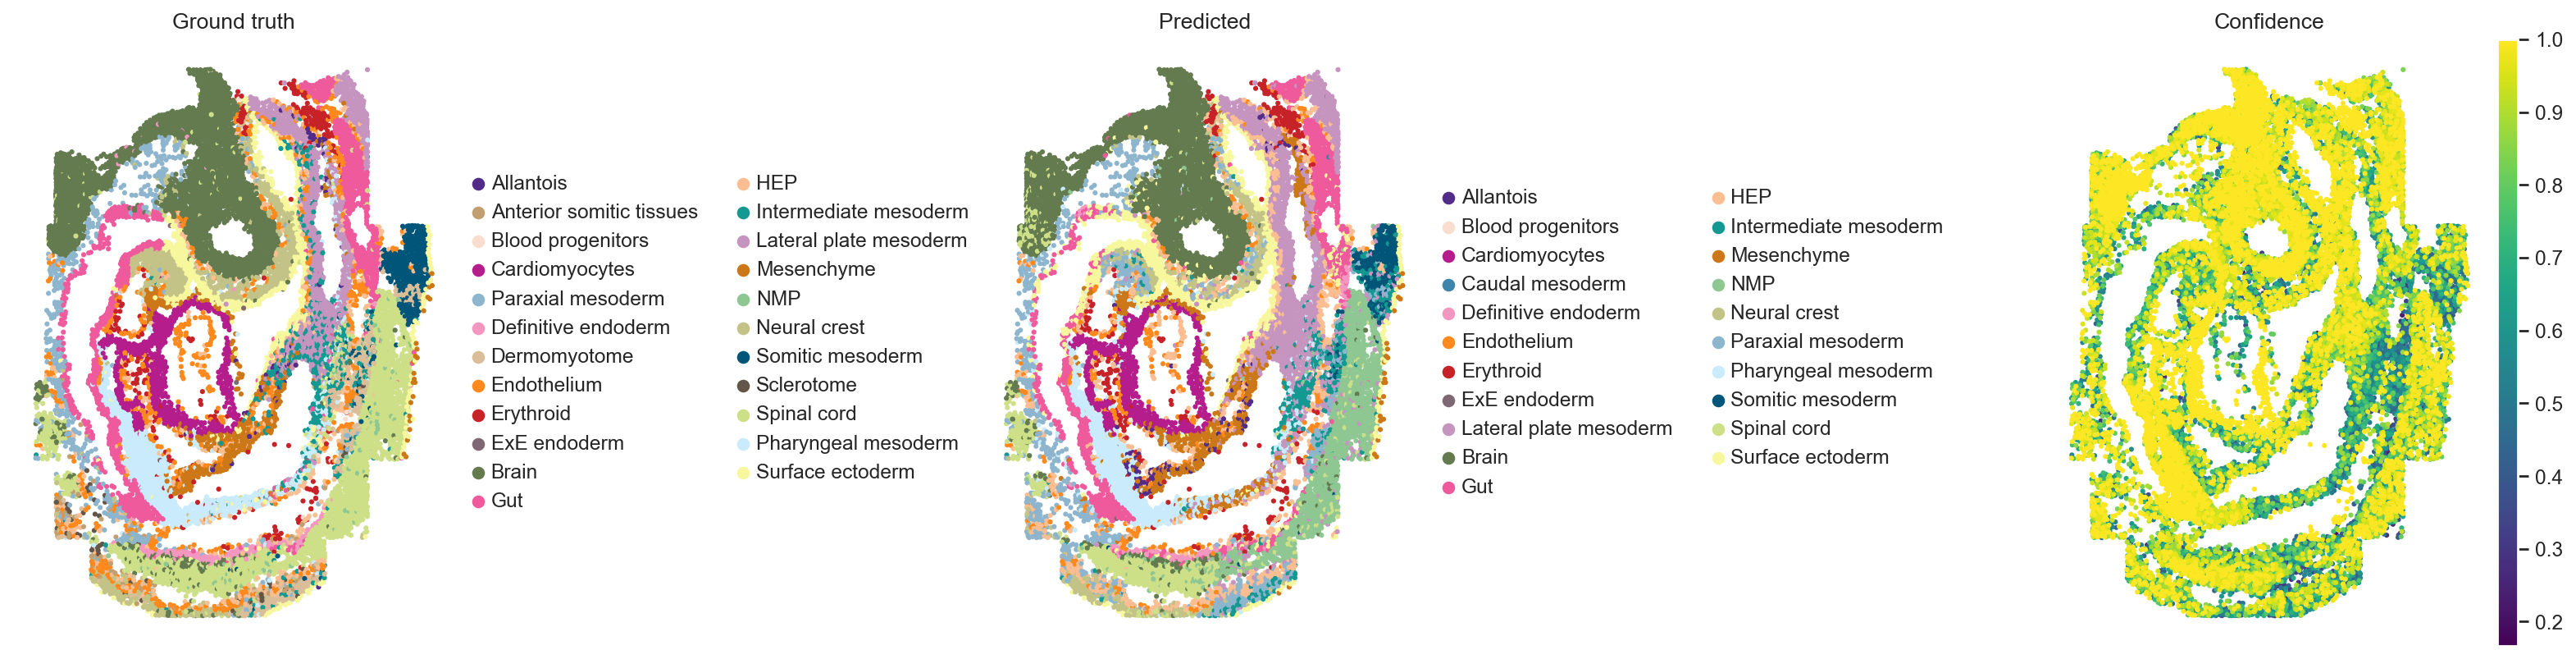

In [87]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.spatial(
        ad_sp[ad_sp.obs["embryo"] == "embryo1"],
        spot_size=1,
        color=["celltype_harmonized", "celltype_harmonized_pred", "celltype_harmonized_conf"],
        title=["Ground truth", "Predicted", "Confidence"],
        ncols=3,
        size=2,
        cmap = "viridis",
        wspace=0.4,
    )

### Compute integration metrics
Finally, we compare the DiagVI latent space against a sinple baseline (PCA computed on the concatenated datasets) using the [scib-metrics](https://scib-metrics.readthedocs.io/en/stable/) package, which implements a standardized collection of metrics for evaluating integration performance and biological signal preservation in latent representations.

In [88]:
bm = Benchmarker(
    combined,
    batch_key="modality",
    label_key="celltype_harmonized",
    embedding_obsm_keys=["X_pca", DIAGVI_LATENT_KEY],
    n_jobs=-1,
)
bm.benchmark()

/Users/hannahwinter/Documents/ETH/MasterThesis/DiagVI/diagVI_analysis/.pixi/envs/default/lib/python3.12/site-packages/scib_metrics/benchmark/_core.py:193: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  sc.tl.pca(self._adata, svd_solver=self._solver, use_highly_variable=False)
Embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

INFO     Anterior somitic tissues consists of a single batch or is too small. Skip.                                
INFO     Caudal mesoderm consists of a single batch or is too small. Skip.                                         
INFO     Dermomyotome consists of a single batch or is too small. Skip.                                            
INFO     Notochord consists of a single batch or is too small. Skip.                                               
INFO     PGC consists of a single batch or is too small. Skip.                                                     
INFO     Parietal endoderm consists of a single batch or is too small. Skip.                                       
INFO     Rostral neurectoderm consists of a single batch or is too small. Skip.                                    
INFO     Sclerotome consists of a single batch or is too small. Skip.                                              
INFO     Visceral endoderm consists of a single batch or is too small. S

/Users/hannahwinter/Documents/ETH/MasterThesis/DiagVI/diagVI_analysis/.pixi/envs/default/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  50%|█████     | 1/2 [03:34<03:34, 214.91s/it]

INFO     Anterior somitic tissues consists of a single batch or is too small. Skip.                                
INFO     Caudal mesoderm consists of a single batch or is too small. Skip.                                         
INFO     Dermomyotome consists of a single batch or is too small. Skip.                                            
INFO     Notochord consists of a single batch or is too small. Skip.                                               
INFO     PGC consists of a single batch or is too small. Skip.                                                     
INFO     Parietal endoderm consists of a single batch or is too small. Skip.                                       
INFO     Rostral neurectoderm consists of a single batch or is too small. Skip.                                    
INFO     Sclerotome consists of a single batch or is too small. Skip.                                              
INFO     Visceral endoderm consists of a single batch or is too small. S

/Users/hannahwinter/Documents/ETH/MasterThesis/DiagVI/diagVI_analysis/.pixi/envs/default/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings: 100%|██████████| 2/2 [06:43<00:00, 201.98s/it]


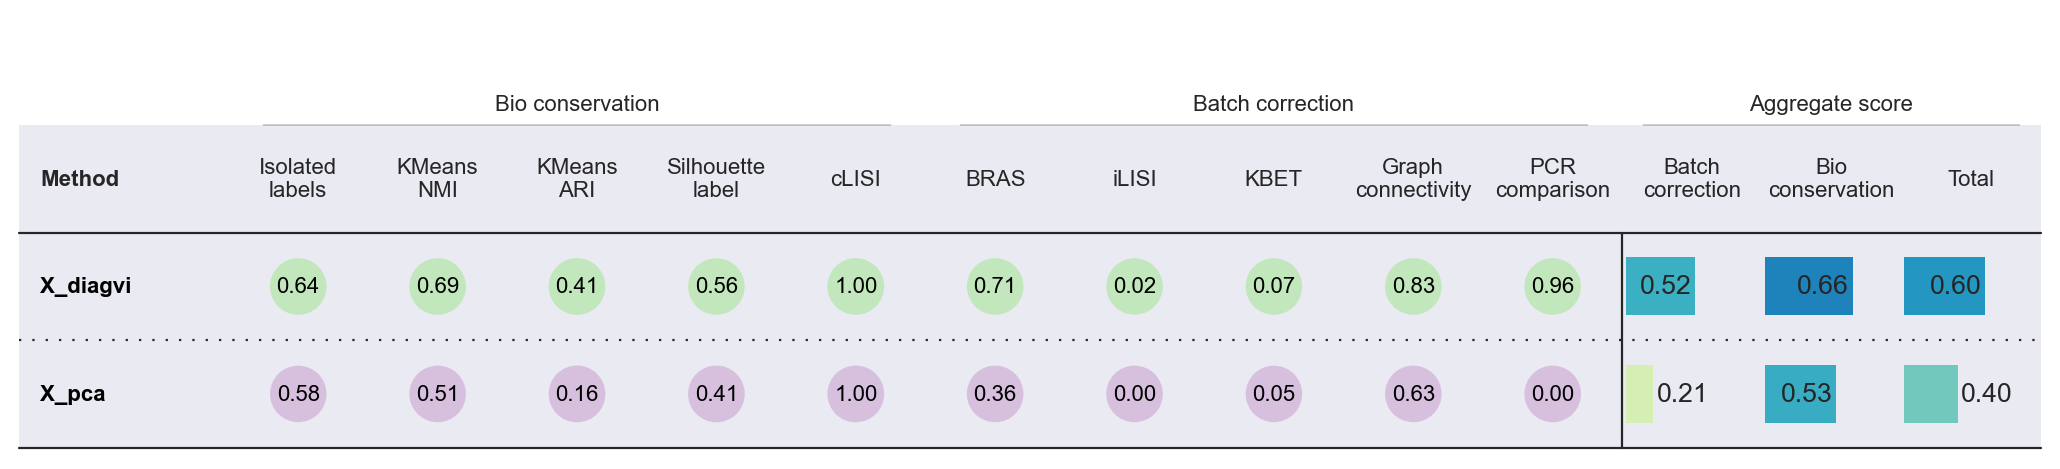

In [89]:
bm.plot_results_table(min_max_scale=False)

### Save and load model

We can save the trained model for later use.

In [ ]:
# model_dir = os.path.join(save_dir.name, "diagvi_model")
# model.save(model_dir, overwrite=True)

In [ ]:
# To load the model later:
# model = DIAGVI.load(model_dir, adatas=input_dict)